In [173]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [46]:
import re

In [25]:
#pull HTML from webpage and create BeautifulSoup object
def cook_soup(url): 
    webpage = requests.get(url)
    soup = BeautifulSoup(webpage.content, 'html.parser')
    return soup

In [147]:
#function intakes a headline string and parses the string based on regex.  
#function returns a list of strings 
def single_airline_parse(headline):
    regex = r"([A-Za-z0-9\s]+)\s([A-Z0-9]{1,5})\s(?:at|near)\s(.+)(?:\son\s)([A-Za-z0-9\s]+)(?:,\s)(.+)"
    groups = re.search(regex, headline)
    return groups

In [169]:
#function intakes the base url for website and the number of pages user would like to scrape,
#and outputs a list of headline dictionaries
def create_df(initial_url,num_pages):
    
    url = initial_url
    #empty list will hold each headline dictionary
    all_headlines = []
    
    #code will run for each page that needs to be scraped
    for page in range(1,num_pages+1):
        #creating BeautifulSoup object from scraped webpage
        soup = cook_soup(url)
        #narrow the HTML of soup to reference only the table of headlines
        table =  soup.findAll('span',{'class':'headline_avherald'})
        #find "Next" button and get the URL path associated
        next_page = soup.find("img", {"title": "Next"}).parent.get('href')
        
        #code will run for each headline in the table of headlines
        for report in table:
            #finding the incident class
            inc_class = report.parent.parent.parent.find('img')['title']
            #finding the headline as a long string
            headline = report.get_text()
            #skip cases with two airlines or two locations listed
            if ' and ' not in headline.partition(' on ')[0]:
                #run regex parser
                parsed_headline = single_airline_parse(headline)
                #if regex parser returns some value, create a headline dictionary of parsed strings
                if parsed_headline:
                    hl_dict = {}
                    hl_dict['Class'] = inc_class
                    hl_dict['Airline'] = parsed_headline[1]
                    hl_dict['Aircraft'] = parsed_headline[2]
                    hl_dict['Location'] = parsed_headline[3]
                    hl_dict['Date'] = parsed_headline[4]
                    hl_dict['Description'] = parsed_headline[5]
                    all_headlines.append(hl_dict)
        #update url with the path associated with the "Next" button
        url = initial_url+next_page
        
    return all_headlines

In [170]:
df = create_df("http://avherald.com/",10)

In [172]:
len(df)

451

In [361]:
incidents = pd.DataFrame(df)
incidents.head()

,Aircraft,Airline,Class,Date,Description,Location
0,B738,Pobeda,Incident,Mar 23rd 2019,lightning strike,Sochi
1,B789,Aeromexico,Incident,Mar 23rd 2019,problem with cockpit oxygen,Lima
2,F100,Iran,Accident,Mar 19th 2019,main gear did not extend,Tehran
3,A332,American,Incident,Mar 22nd 2019,pack problem,Munich
4,B737,BoA,Incident,Mar 22nd 2019,engine shut down in flight,Cochabamba


In [381]:
incidents.describe()

,Aircraft,Airline,Class,Date,Description,Location
count,450,450,450,450,450,450
unique,69,222,5,174,294,277
top,A320,American,Incident,Feb 25th 2019,engine shut down in flight,Amsterdam
freq,56,20,375,11,32,12


In [382]:
incidents.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 450 entries, 0 to 450
Data columns (total 6 columns):
Aircraft       450 non-null object
Airline        450 non-null object
Class          450 non-null object
Date           450 non-null object
Description    450 non-null object
Location       450 non-null object
dtypes: object(6)
memory usage: 24.6+ KB


In [182]:
incidents['Aircraft'].value_counts().head(5)

A320    57
B738    55
A321    21
B763    18
B773    18
Name: Aircraft, dtype: int64

In [183]:
incidents['Airline'].value_counts().head(5)

American    20
Canada      14
Delta       13
United      11
Jazz         8
Name: Airline, dtype: int64

In [187]:
import datetime
import time

In [247]:
#function intakes a date string and strips it of 'rd', 'th', 'nd', 'st' following the date number 
#ie, turns March 23rd 2019 to March 23 2019
def convert_to_date(date):
    if 'rd ' in date:
        return date.replace('rd','')
    elif 'th ' in date:
        return date.replace('th','')
    elif 'nd ' in date:
        return date.replace('nd','')
    elif 'st ' in date:
        return date.replace('st','')

In [248]:
incidents['Date'] = incidents['Date'].map(convert_to_date)

In [249]:
#function intakes a date string and converts it to a datetime object
def convert_to_datetime(date):
    return time.strptime(date, '%b %d %Y')

In [250]:
#creating a new column in the df for datetime object
incidents['datetime'] = incidents['Date'].map(convert_to_datetime)

In [255]:
#creating new column in df for year, month, and day
incidents['Year'] = [dt.tm_year for dt in incidents['datetime']]
incidents['Month'] = [dt.tm_mon for dt in incidents['datetime']]

day_dict = {0:'Monday',1:'Tuesday',2:'Wednesday',3:'Thursday',4:'Friday',5:'Saturday',6:'Sunday'}
incidents['Day'] = [day_dict[dt.tm_wday] for dt in incidents['datetime']]

In [348]:
incidents.head(20)

,Aircraft,Airline,Class,Date,Description,Location,datetime,Year,Month,Day
0,B738,Pobeda,Incident,Mar 23 2019,lightning strike,Sochi,"(2019, 3, 23, 0, 0, 0, 5, 82, -1)",2019,3,Saturday
1,B789,Aeromexico,Incident,Mar 23 2019,problem with cockpit oxygen,Lima,"(2019, 3, 23, 0, 0, 0, 5, 82, -1)",2019,3,Saturday
2,F100,Iran,Accident,Mar 19 2019,main gear did not extend,Tehran,"(2019, 3, 19, 0, 0, 0, 1, 78, -1)",2019,3,Tuesday
3,A332,American,Incident,Mar 22 2019,pack problem,Munich,"(2019, 3, 22, 0, 0, 0, 4, 81, -1)",2019,3,Friday
4,B737,BoA,Incident,Mar 22 2019,engine shut down in flight,Cochabamba,"(2019, 3, 22, 0, 0, 0, 4, 81, -1)",2019,3,Friday
5,A333,Cathay Pacific,Incident,Mar 22 2019,hydraulic failure,Jakarta,"(2019, 3, 22, 0, 0, 0, 4, 81, -1)",2019,3,Friday
6,B773,PIA,Incident,Mar 22 2019,bird strike penetrates leading edge of wing,Lahore,"(2019, 3, 22, 0, 0, 0, 4, 81, -1)",2019,3,Friday
7,A320,United,Incident,Mar 16 2019,duck!,Vancouver,"(2019, 3, 16, 0, 0, 0, 5, 75, -1)",2019,3,Saturday
8,B737,Southwest,Incident,Mar 21 2019,flock of birds on short final,Houston,"(2019, 3, 21, 0, 0, 0, 3, 80, -1)",2019,3,Thursday
9,A320,Jetstar,Report,Sep 20 2018,thrust reversers did not deploy,Sydney,"(2018, 9, 20, 0, 0, 0, 3, 263, -1)",2018,9,Thursday


In [378]:
incidents.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 450 entries, 0 to 450
Data columns (total 10 columns):
Aircraft       450 non-null object
Airline        450 non-null object
Class          450 non-null object
Date           450 non-null object
Description    450 non-null object
Location       450 non-null object
datetime       450 non-null object
Year           450 non-null int64
Month          450 non-null int64
Day            450 non-null object
dtypes: int64(2), object(8)
memory usage: 58.7+ KB


Text(0.5, 1.0, 'Headline Classification')

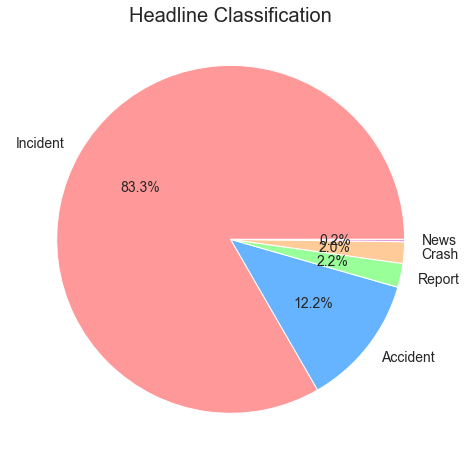

In [433]:
plt.figure(figsize=(8,8))
plt.pie(incidents['Class'].value_counts(),labels = incidents['Class'].unique(),autopct='%1.1f%%',colors = ['#ff9999','#66b3ff','#99ff99','#ffcc99','plum'],
textprops={'fontsize': 14})
plt.title('Headline Classification',{'fontsize': 20,'verticalalignment': 'center'})


Text(0.5, 1.0, 'Headlines per Airline')

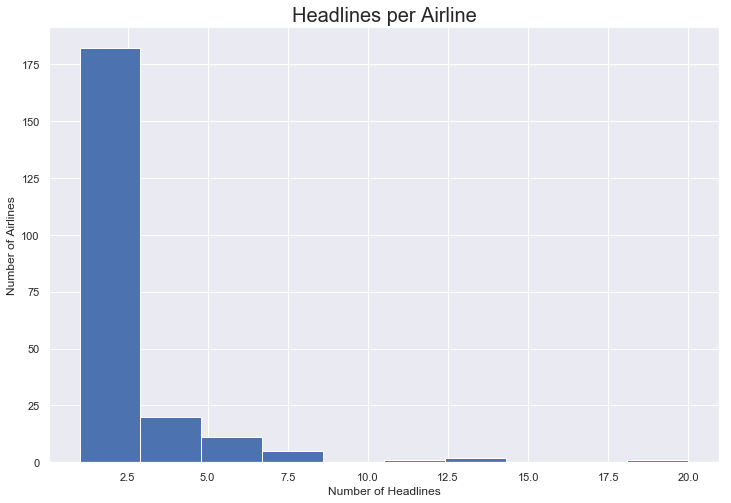

In [391]:
plt.figure(figsize = (12,8))
plt.hist(incidents['Airline'].value_counts())
plt.ylabel('Number of Airlines')
plt.xlabel('Number of Headlines')
plt.title('Headlines per Airline',fontsize=20)

In [393]:
incidents['Airline'].value_counts().head(5)

American    20
Canada      14
Delta       13
United      11
Jazz         8
Name: Airline, dtype: int64

Text(0.5, 1.0, 'Headlines per Aircraft')

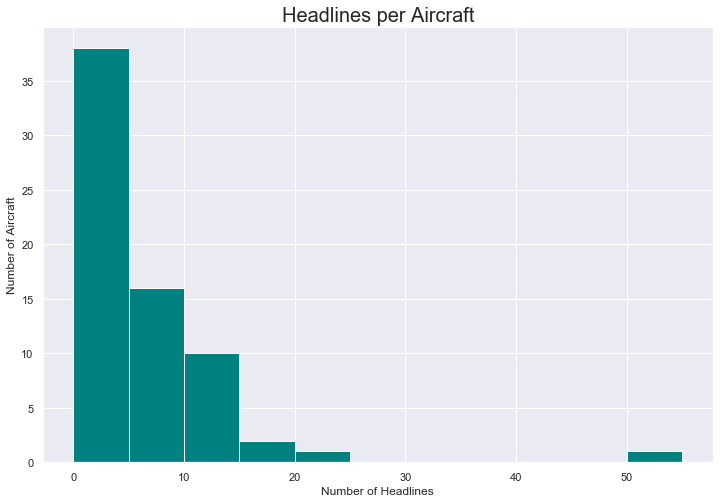

In [407]:
plt.figure(figsize = (12,8))
plt.hist(incidents['Aircraft'].value_counts(),color='teal',bins=list(range(0,60,5)))
plt.ylabel('Number of Aircraft')
plt.xlabel('Number of Headlines')
plt.title('Headlines per Aircraft',fontsize=20)

In [400]:
incidents['Aircraft'].value_counts().head(5)

A320    56
B738    55
A321    21
B763    18
B773    18
Name: Aircraft, dtype: int64

In [319]:
from os import path
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator


In [347]:
text = " ".join(descr for descr in incidents['Description'])
print ("There are {} words in the combination of all review.".format(len(text)))

There are 12301 words in the combination of all review.


In [357]:
stopwords = set(STOPWORDS)
stopwords.update(["problem", "failure","problems","shut down","flight"])

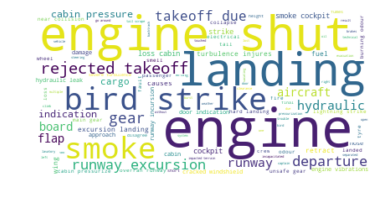

In [358]:
# Create and generate a word cloud image:
wordcloud = WordCloud(stopwords=stopwords,max_words=100,background_color='white').generate(text)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [359]:
wordcloud.to_file("all_descriptions_better.png")

In [410]:
incidents.query('Aircraft == "B38M"')

,Aircraft,Airline,Class,Date,Description,Location,datetime,Year,Month,Day
12,B38M,Lion,Crash,Oct 29 2018,aircraft lost height and crashed into Java Sea...,Jakarta,"(2018, 10, 29, 0, 0, 0, 0, 302, -1)",2018,10,Monday
13,B38M,Ethiopian,Crash,Mar 10 2019,impacted terrain after departure,Bishoftu,"(2019, 3, 10, 0, 0, 0, 6, 69, -1)",2019,3,Sunday
122,B38M,Norwegian,Incident,Dec 14 2018,engine shut down in flight,Shiraz,"(2018, 12, 14, 0, 0, 0, 4, 348, -1)",2018,12,Friday
173,B38M,American,Incident,Feb 12 2019,hydraulic failure,San Juan,"(2019, 2, 12, 0, 0, 0, 1, 43, -1)",2019,2,Tuesday
220,B38M,TUI,Incident,Jan 29 2019,engine problem,Chania,"(2019, 1, 29, 0, 0, 0, 1, 29, -1)",2019,1,Tuesday
230,B38M,Argentinas,Incident,Dec 14 2018,engine vibrations as result of weather,Cordoba,"(2018, 12, 14, 0, 0, 0, 4, 348, -1)",2018,12,Friday
251,B38M,Canada,Incident,Jan 13 2019,rejected takeoff due to door indication,Palm Springs,"(2019, 1, 13, 0, 0, 0, 6, 13, -1)",2019,1,Sunday
261,B38M,Norwegian,Incident,Jan 18 2019,touched down despite go around instruction,Helsinki,"(2019, 1, 18, 0, 0, 0, 4, 18, -1)",2019,1,Friday
288,B38M,Canada,Incident,Dec 29 2018,failure of wing anti-ice,Vancouver,"(2018, 12, 29, 0, 0, 0, 5, 363, -1)",2018,12,Saturday
333,B38M,Spicejet,Incident,Jan 6 2019,engine shut down in flight,Varanasi,"(2019, 1, 6, 0, 0, 0, 6, 6, -1)",2019,1,Sunday


/Users/samantha/anaconda3/lib/python3.7/site-packages/pandas/plotting/_core.py:185: UserWarning: 'colors' is being deprecated. Please use 'color'instead of 'colors'
  warnings.warn(("'colors' is being deprecated. Please use 'color'"


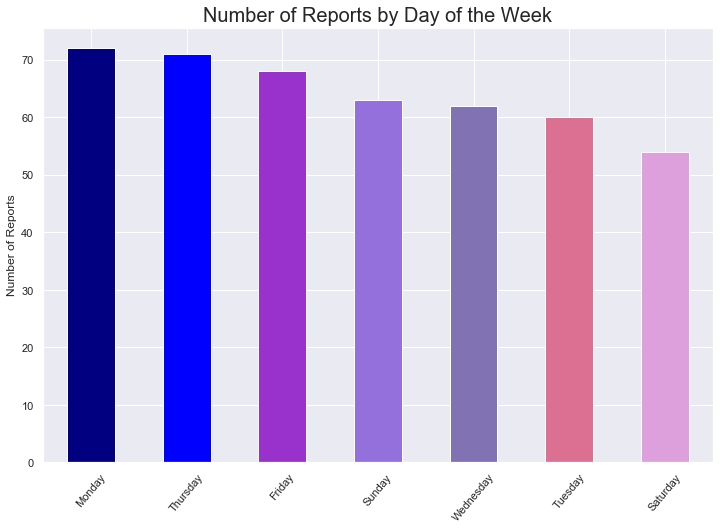

In [425]:
plt.figure(figsize=(12,8))
incidents['Day'].value_counts().plot.bar(colors=['navy','blue','darkorchid','mediumpurple','m','palevioletred','plum'])
plt.xticks(rotation=50)
plt.ylabel("Number of Reports")
plt.title('Number of Reports by Day of the Week', fontsize=20)
plt.show()